In [1]:
import sys
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python')
import time
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
#import fill_values as fv
#import calc_station_properties as cs

import createFolder as cF
from scipy.integrate import simps
import fcts_read_stat as rs


In [7]:
thredds      = 'http://thredds.met.no/thredds/dodsC/metusers/dagb/Franziska'

stn_name     = 'Haukeliseter'
stn_lat      = 59.81
stn_lon      = 7.21
#stn_name     = 'Stavanger'
#stn_lat      = 58.87
#stn_lon      = 5.67

year        = 2016
month        = 12
day          = 26
forecasttime = '00'

In [45]:
def mask_array(variable, #ens_memb, 
               y, x, EM):
    if EM == 10:
        if np.ma.is_masked(variable[:,:,#ens_memb,
                                    y,x]):
            mask = np.ma.getmaskarray(variable[:,:,#ens_memb,
                                               y,x])  
            fill_value = np.nan
            marr = np.ma.array(variable[:,:,#ens_memb,
                                        y,x], mask = mask, fill_value = fill_value)
            dtype = marr.filled().dtype
            filled = marr.filled()
        else:
            fill_value = np.nan
            marr = variable[:,:,:,#ens_memb,
                        y,x]
            filled = marr
            dtype = marr.dtype
    elif EM == 1:
        if np.ma.is_masked(variable[:,:,y,x]):
            mask = np.ma.getmaskarray(variable[:,:,y,x])  
            fill_value = np.nan
            marr = np.ma.array(variable[:,:,y,x], mask = mask, fill_value = fill_value)
            dtype = marr.filled().dtype
            filled = marr.filled()
        else:
            fill_value = np.nan
            marr = variable[:,:,y,x]
            filled = marr
            dtype = marr.dtype
    return(filled, dtype)

In [47]:
fn = dict()
latitude  = dict()
longitude = dict()
x = dict()
y = dict()

ap = dict()
b = dict()
surface_air_pressure = dict()
air_temperature_0m = dict()
air_temperature_ml = dict()
dtype_sap  = dict()
dtype_at0m =  dict()
dtype_atml = dict()

In [49]:
for ens_memb in range(10):
    fn[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s/meps_mbr00%s_%s%s%s%s.nc' %(thredds,year,month,day,forecasttime,ens_memb,year,month,day,forecasttime),'r')

    ## Latitudes
    ## [y = 949][x = 739]
    latitude[ens_memb] = fn[ens_memb].variables['latitude']

    ## Longitudes 
    ## [y = 949][x = 739]
    longitude[ens_memb] = fn[ens_memb].variables['longitude']

    # Now find the absolute value of the difference between the  station's lat/lon with every point in the grid. 
    x[ens_memb],y[ens_memb] = rs.find_station_yx(latitude[ens_memb], longitude[ens_memb], stn_lat, stn_lon)
    y[ens_memb] = y[ens_memb][0]
    x[ens_memb] = x[ens_memb][0]

    
    ######## with Vertical Levels ( hybrid )#################################
    ## hybrid levels atmosphere_hybrid_sigma_pressure_coordinate
    # formula: p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
    # positive: down


    ### variables to calculate pressure
    #p0 = fn.variables['p0']    ## p0: p0
    ap[ens_memb] = fn[ens_memb].variables['ap'][:]    ## ap: ap
    b[ens_memb] = fn[ens_memb].variables['b'][:]      ## b: b
    
    surface_air_pressure[ens_memb] = fn[ens_memb].variables['surface_air_pressure'][:]
    air_temperature_0m[ens_memb]   = fn[ens_memb].variables['air_temperature_0m'][:]
    air_temperature_ml[ens_memb]   = fn[ens_memb].variables['air_temperature_ml']
    
    ### mask arrays
    

In [50]:
for ens_memb in range(10):
    surface_air_pressure[ens_memb], dtype_sap[ens_memb]  = mask_array(surface_air_pressure[ens_memb], 
                                                      y[ens_memb], x[ens_memb],EM=1)
    air_temperature_0m[ens_memb],   dtype_at0m[ens_memb] = mask_array(air_temperature_0m[ens_memb],    
                                                      y[ens_memb], x[ens_memb],EM=1)
    air_temperature_ml[ens_memb],   dtype_atml[ens_memb] = mask_array(air_temperature_ml[ens_memb],  
                                                     y[ens_memb], x[ens_memb],EM=1)


In [150]:




### Transfer pressure coordinate
p_interface = ap[:]+b[:]*surface_air_pressure[:,:]
    

### 1) Connect interface values and surface values for pressure
### Pressure
p_interfaces2 = np.concatenate((p_interface[:,:],surface_air_pressure[:,:]),axis=1)

# transform hybrid sigma pressure coordinates at interface levels to pressure at model levels
p_ml = np.empty([p_interfaces2.shape[0],p_interfaces2.shape[1]-1])
for i in range(0,p_interfaces2.shape[1]-1):
    p_ml[:,i] = 1/2 * (p_interfaces2[:,i] + p_interfaces2[:,i+1])
p_ml = np.concatenate((p_ml[:,:],surface_air_pressure[:,:]),axis=1)
    
### --> Now the pressure is calculated at each model level

### 2) Connect model levels and surface values for temperature
### Temperature
temperature_ml = np.concatenate((air_temperature_ml[:,:],
                                        air_temperature_0m[:,:]),axis=1)

    

dz, dgeop = rs.get_thickness(p_ml, temperature_ml)


In [151]:
thickness = dz
h_above = []
h_above.append(np.zeros(thickness[:,:].shape[0]))
th_arr = np.nansum([np.asarray(h_above)[:,0], thickness[:,0]], axis = 0)
h_above.append(th_arr)
for i in range(2,thickness[:,:].shape[1]):    
    th_arr = np.nansum([h_above[i-1], thickness[:,i-1]], axis = 0)
    h_above.append(th_arr)
height_ml = np.transpose(h_above) 

In [152]:
pressure_ml = p_ml[:,0:-1]

In [153]:
####
# calculate density at each level
Rd = 287.
density_ml = pressure_ml/(Rd*air_temperature_ml)

In [154]:
mass_fraction_of_snow_in_air_ml = fn.variables['mass_fraction_of_snow_in_air_ml'][:,:,y,x]


In [155]:
mass_fraction_of_cloud_condensed_water_in_air_ml = fn.variables['mass_fraction_of_cloud_condensed_water_in_air_ml'][:,:,y,x]

In [156]:
mass_fraction_of_cloud_ice_in_air_ml = fn.variables['mass_fraction_of_cloud_ice_in_air_ml'][:,:,y,x]

In [157]:
mass_fraction_of_graupel_in_air_ml = fn.variables['mass_fraction_of_graupel_in_air_ml'][:,:,y,x]

In [158]:
mass_fraction_of_rain_in_air_ml = fn.variables['mass_fraction_of_rain_in_air_ml'][:,:,y,x]

In [159]:
ice = mass_fraction_of_snow_in_air_ml + mass_fraction_of_cloud_ice_in_air_ml + mass_fraction_of_graupel_in_air_ml

In [160]:
# convert from [kg/kg] to [kg/m^3]
ice_amount_ml = (ice*density_ml)

In [161]:
# convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
ice_amount_ml = (ice_amount_ml*1000.)

In [162]:
height_ml.shape

(49, 65)

In [163]:
time = fn.variables['time'][:]

In [164]:
time.shape, height_ml.shape, (ice_amount_ml).shape

((49,), (49, 65), (49, 65))

In [165]:
mass_fraction_of_cloud_condensed_water_in_air_ml.shape

(49, 65)

In [166]:
lead_time = np.arange(0,mass_fraction_of_cloud_condensed_water_in_air_ml.shape[0])
model_level = np.arange(0,mass_fraction_of_cloud_condensed_water_in_air_ml.shape[1])
td,Y = np.meshgrid(lead_time,model_level,)

In [167]:
height_MRR = np.arange(300,3100,200)

In [168]:
time_MEPS = np.empty(shape=(td.shape[1], height_MRR.shape[0]))
height_MEPS = np.empty(shape=(height_ml.shape[0], height_MRR.shape[0]))
SWC_MEPS = np.empty(shape=(ice_amount_ml.shape[0], height_MRR.shape[0]))
for i in range(height_ml.shape[0]):
    for k in range(height_MRR.shape[0]):
        idx1 = (np.abs(height_ml[i,:] - np.array(height_MRR)[k]).argmin())
        
        height_MEPS[i,k] = height_ml[i,idx1]
        time_MEPS[i,k]   = td[idx1,i]
        SWC_MEPS[i,k]    = ice_amount_ml[i,idx1]

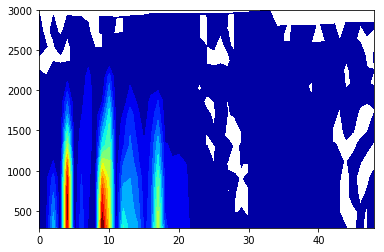

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(time_MEPS, height_MEPS, np.fliplr(SWC_MEPS), np.arange(0,1.5,0.1), vmin=0, vmax=1.5, cmap='jet',extend='max')

In [ ]:
memb = np.arange(0,1)

In [ ]:
######## with Vertical Levels ( hybrid )#################################
## hybrid levels atmosphere_hybrid_sigma_pressure_coordinate
# formula: p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
# positive: down


### variables to calculate pressure
#p0 = fn.variables['p0']    ## p0: p0
ap = fn.variables['ap']    ## ap: ap
b = fn.variables['b']      ## b: b

surface_air_pressure = fn.variables['surface_air_pressure']
air_temperature_0m   = fn.variables['air_temperature_0m']
air_temperature_ml   = fn.variables['air_temperature_ml']

In [ ]:
def mask_array(variable, #ens_memb, 
               y, x, EM):
    if EM == 10:
        if np.ma.is_masked(variable[:,:,:,#ens_memb,
                                    y,x]):
            mask = np.ma.getmaskarray(variable[:,:,:,#ens_memb,
                                               y,x])  
            fill_value = np.nan
            marr = np.ma.array(variable[:,:,:,#ens_memb,
                                        y,x], mask = mask, fill_value = fill_value)
            dtype = marr.filled().dtype
            filled = marr.filled()
        else:
            fill_value = np.nan
            marr = variable[:,:,:,#ens_memb,
                        y,x]
            filled = marr
            dtype = marr.dtype
    elif EM == 1:
        if np.ma.is_masked(variable[:,:,y,x]):
            mask = np.ma.getmaskarray(variable[:,:,y,x])  
            fill_value = np.nan
            marr = np.ma.array(variable[:,:,y,x], mask = mask, fill_value = fill_value)
            dtype = marr.filled().dtype
            filled = marr.filled()
        else:
            fill_value = np.nan
            marr = variable[:,:,y,x]
            filled = marr
            dtype = marr.dtype
    return(filled, dtype)

In [ ]:
### mask arrays
surface_air_pressure, dtype_sap  = mask_array(surface_air_pressure, #ens_memb, 
                                                  y, x,EM=1)
air_temperature_0m,   dtype_at0m = mask_array(air_temperature_0m,   #ens_memb, 
                                                  y, x,EM=1)
air_temperature_ml,   dtype_atml = mask_array(air_temperature_ml,   #ens_memb, 
                                                  y, x,EM=1)

In [ ]:
surface_air_pressure.shape

In [ ]:
def get_value_at_station(fn, variable, y, x):
    variable = fn.variables[variable]
    variable, dtype = mask_array(variable,y,x,EM=1)
    variable = np.fliplr(variable)
    variable = np.ma.masked_where(np.isnan(variable), variable)
    return(variable)

In [ ]:
for ens_memb in memb:
### Transfer pressure coordinate
    p_interface = ap[:]+b[:]*surface_air_pressure[:,:]

### 1) Connect interface values and surface values for pressure
### Pressure
    p_interfaces2 = np.concatenate((p_interface[:,:],surface_air_pressure[:,:]),axis=1)

# transform hybrid sigma pressure coordinates at interface levels to pressure at model levels
    p_ml = np.empty([p_interfaces2.shape[0],p_interfaces2.shape[1]-1])
    for i in range(0,p_interfaces2.shape[1]-1):
        p_ml[:,i] = 1/2 * (p_interfaces2[:,i] + p_interfaces2[:,i+1])
    p_ml = np.concatenate((p_ml[:,:],surface_air_pressure[:,:]),axis=1)
    
### --> Now the pressure is calculated at each model level

### 2) Connect model levels and surface values for temperature
### Temperature
    temperature_ml = np.concatenate((air_temperature_ml[:air_temperature_ml.shape[0],:],
                                        air_temperature_0m[:air_temperature_ml.shape[0],:]),axis=1)

    

    dz, dgeop = rs.get_thickness(p_ml, temperature_ml)

    if ens_memb == 0:
        pressure_in_modellev = p_ml[:,0:-1]
        thickness_m   = dz
        thickness_phi = dgeop  
    else:
        pressure_in_modellev = np.dstack((pressure_in_modellev,p_ml[:,0:5]))
        thickness_m   = np.dstack((thickness_m,dz))
        thickness_phi = np.dstack((thickness_phi,dgeop))

pressure_in_modellev = np.ma.array(pressure_in_modellev,mask=np.ma.is_masked(pressure_in_modellev), 
                                       fill_value = np.nan)
thickness_m = np.ma.array(thickness_m,mask=np.ma.is_masked(thickness_m), 
                                       fill_value = np.nan)
thickness_phi = np.ma.array(thickness_phi,mask=np.ma.is_masked(thickness_phi), 
                                       fill_value = np.nan)

In [ ]:
# Read in all values needed to present the microphysics
## Time
time_arr = fn.variables['time']
#ensemble_member_arr = fn.variables['ensemble_member']

## heights
height_above_msl_arr = fn.variables['height_above_msl']
height0_arr = fn.variables['height0']
height1_arr = fn.variables['height1']
height3_arr = fn.variables['height3']
hybrid_arr = fn.variables['hybrid']





######## with Vertical Levels ( height0 ) #################################
liquid_water_content_of_surface_snow = get_value_at_station(fn, 'liquid_water_content_of_surface_snow',y,x)
air_temperature_0m                   = get_value_at_station(fn, 'air_temperature_0m', y,x)
rainfall_amount                      = get_value_at_station(fn, 'rainfall_amount',y,x)
snowfall_amount                      = get_value_at_station(fn, 'snowfall_amount',y,x)
graupelfall_amount                   = get_value_at_station(fn, 'graupelfall_amount', y,x)
surface_air_pressure                 = get_value_at_station(fn, 'surface_air_pressure',y,x)
surface_geopotential                 = get_value_at_station(fn, 'surface_geopotential',y,x)
precipitation_amount_acc             = get_value_at_station(fn, 'precipitation_amount_acc',y,x)
int_rainfall_amount_wrt_time         = get_value_at_station(fn, 'integral_of_rainfall_amount_wrt_time',y,x)
int_snowfall_amount_wrt_time         = get_value_at_station(fn, 'integral_of_snowfall_amount_wrt_time',y,x)
int_graupelfall_amount_wrt_time      = get_value_at_station(fn, 'integral_of_graupelfall_amount_wrt_time',y,x)        
        
######## with Vertical Levels ( height1 )#################################
air_temperature_2m   = get_value_at_station(fn,'air_temperature_2m',y,x)
relative_humidity_2m = get_value_at_station(fn,'relative_humidity_2m',y,x)   
specific_humidity_2m = get_value_at_station(fn,'specific_humidity_2m',y,x) 

######## with Vertical Levels ( height3 )#################################
x_wind_10m = get_value_at_station(fn,'x_wind_10m',y,x)
y_wind_10m = get_value_at_station(fn,'y_wind_10m',y,x)

######## with Vertical Levels ( height_above_msl )#################################
air_pressure_at_sea_level = get_value_at_station(fn,'air_pressure_at_sea_level',y,x)

######## with Vertical Levels ( hybrid )#################################
## hybrid levels atmosphere_hybrid_sigma_pressure_coordinate
# formula: p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
# positive: down

## values in fn file
specific_humidity_ml     = get_value_at_station(fn,'specific_humidity_ml',y,x)
cloud_condensed_water_ml = get_value_at_station(fn,'mass_fraction_of_cloud_condensed_water_in_air_ml',y,x)
cloud_ice_ml             = get_value_at_station(fn,'mass_fraction_of_cloud_ice_in_air_ml',y,x)
snow_ml                  = get_value_at_station(fn,'mass_fraction_of_snow_in_air_ml',y,x)
rain_ml                  = get_value_at_station(fn,'mass_fraction_of_rain_in_air_ml',y,x)
graupel_ml               = get_value_at_station(fn,'mass_fraction_of_graupel_in_air_ml',y,x)
pressure_departure       = get_value_at_station(fn,'pressure_departure',y,x)
air_temperature_ml       = get_value_at_station(fn,'air_temperature_ml',y,x)
x_wind_ml                = get_value_at_station(fn,'x_wind_ml',y,x)
y_wind_ml                = get_value_at_station(fn,'y_wind_ml',y,x)



In [ ]:
# calculate density at each level
density_ml = pressure_in_modellev/(Rd*air_temperature_ml)

# convert from [kg/kg] to [kg/m^3]
cloud_condensed_water_ml = (cloud_condensed_water_ml*density_ml)
cloud_ice_ml = (cloud_ice_ml*density_ml)
snow_ml = (snow_ml*density_ml)
rain_ml = (rain_ml*density_ml)
graupel_ml = (graupel_ml*density_ml)


# convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
cloud_condensed_water_ml = (cloud_condensed_water_ml*1000.)
cloud_ice_ml = (cloud_ice_ml*1000.)
snow_ml = (snow_ml*1000.)
rain_ml = (rain_ml*1000.)
graupel_ml = (graupel_ml*1000)

# get ice amount (snow+graupel+cloud_ice)
ice_amount_ml = snow_ml + graupel_ml + cloud_ice_ml

# get liquid amount (rain+cloud_water)
water_amount_ml = rain_ml+cloud_condensed_water_ml

In [ ]:
####
# create 2d time array
time_arr = np.repeat(time_arr, pressure_in_modellev.shape[1], axis = 0)
time_arr = np.reshape(time_arr, (-1, pressure_in_modellev.shape[1]))

In [ ]:
# layer thickness to calculate height
thickness_ml     = thickness_m
h_above = []
h_above.append(np.zeros(thickness_ml[:,:].shape[0]))
th_arr = np.nansum([np.asarray(h_above)[:,0], thickness_ml[:,0]], axis = 0)
h_above.append(th_arr)
for i in range(2,thickness_ml[:,:].shape[1]):
    th_arr = np.nansum([h_above[i-1], thickness_ml[:,i-1]], axis = 0)
    h_above.append(th_arr)
height_ml = np.transpose(h_above) 

In [ ]:
np.max(ice_amount_ml)

In [ ]:
np.max(water_amount_ml)

In [ ]:
np.max(rain_ml)

In [ ]:
np.max(cloud_condensed_water_ml)

In [ ]:
year = 2016
month = 12
ini_day = 20

In [ ]:
cc = 'snow+graupel+cloud ice'
plt_cloud_content(time_arr,height_ml,ice_amount_ml,cc)

In [ ]:
cc = 'rain+cloud water'
plt_cloud_content(time_arr,height_ml,water_amount_ml,cc)

In [ ]:
from matplotlib.gridspec import GridSpec

In [ ]:
def plt_cloud_content(time_arr,height_ml,cloud_content_ml,cc):
    
    ##### define things which are set for all #####
    champ = 255.
    vert_col = np.array([197,197,197])/champ    # vertical line for day marker

    
    #var_label = 'SWC [g m$^{-3}$]'
    var_label = 'Cloud content [g m$^{-3}$]'
    label_txt = 'height [km]'

    xmax = 24.
    ymax = 12500.

    xdays = ['%s-%s-%s' %(year,month,ini_day), '', 
        6, '',12, '', 18, '',
        '%s-%s-%s' %(year,month,ini_day+1),  '',
        6, '', 12, '', 18, '',
        '%s-%s-%s' %(year,month,ini_day+2)]
    
#    yticks3 = np.arange(0,14000.,2000)
 #   yticks = yticks3
    yticks3 = np.arange(0,4000.,1000)
    yticks = yticks3
    
    
    
    #levels = np.arange(0,1.51,0.01)
    levels = np.arange(0.,0.1,0.001)
    levels = np.arange(0., np.nanmax(cloud_content_ml),0.0001)

    #cb_ticks = []
    cb_ticks = levels[::30]
    
    
#    if np.max(cloud_content_ml) < 0.0001:
 #       print('cloud content < 0.001')
  #      return
   # else:
        
        
    ##### begin figure #####
    fig =plt.figure(figsize=(10,3))

    gs = GridSpec(2,3)
    ax0 = plt.subplot(gs[0,:-1])
    im0 = ax0.contourf(time_arr,height_ml,cloud_content_ml,#levels, 
            cmap='jet', extend = 'max', alpha = 1.0, 
       #    vmin = 0, vmax = 0.3, 
            origin = 'lower')
    #ax0.axis([time_arr[0,0], time_arr[-1,0], 0., ymax])
    ax0.axis([time_arr[0,0], time_arr[-1,0], 0., 4000])
    ax0.set_xticks( np.arange(time_arr[0,0],time_arr[-1,0],3*60*60))
    #ax0.get_xaxis().set_tick_params(width=5)
    ax0.set_xticklabels(xdays)

    ax0.set_yticks(yticks)
    ax0.set_ylabel(label_txt)#, fontsize = label_fs-2)

#ax.xaxis.grid()
# Vertical line to show end of day
    ax0.axvline(time_arr[0,0],color = vert_col, linewidth = 3)
    ax0.axvline(time_arr[24,0],color = vert_col, linewidth = 3)
    ax0.axvline(time_arr[-1,0],color = vert_col, linewidth = 3)


    ax31 = plt.subplot(gs[1,-1])
    ax31.axis('off')
    cbaxes = fig.add_axes([0.685, .275, 0.017, 0.66])  # [left, bottom, width, height] 
    cbar = fig.colorbar(im0, cax=cbaxes, #ticks = cb_ticks, 
                    orientation = 'vertical')#, pad=0.20, fraction = 0.08, shrink = 2.5)
    cbar.ax.tick_params()#labelsize= tick_fs-2)
    cbar.ax.set_ylabel(var_label)#,fontsize = label_fs-2)

    

    ax0.set_title('Cloud content MEPS$_{CONTROL}$')
    
    
    ax0.text(0.02,0.95, #'SWC$_{Retrieval\,\,3h}$' ,
                 cc ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax0.transAxes,
             color = 'k', #ontsize = im.fontsize,
             bbox={'facecolor':'white','alpha':1.,'pad':3})
    
#    lgd = plt.tight_layout(pad=1.4, w_pad=1.5, h_pad=1.5)
 #   return(lgd)